
First we specify some data augmentations with [Transforms V2](https://pytorch.org/vision/stable/auto_examples/plot_transforms_v2.html) for both the training and testing sets. The following transforms are applied to the `train_transform` object:

- `RandomRotation`: Rotates the image between 0 and 30 degrees
  
- `RandomHorizontalFlip`: Randomly flips an image along the horizontal axis
  
- `ToImageTensor`: transforms input image into a `torch.Tensor`
  
- `ConvertImageDtype`: converts elements in tensors to `float32` dtype – necessary for development on M-series MacBooks.
  
- `Normalize`: Normalize tensor values such that the mean and standard deviation of the images become `0.0` and `1.0` respectively. Per-color mean and standard deviation values were calculated w.r.t. this [guide](https://saturncloud.io/blog/how-to-normalize-pytorch-cifar10-images-for-improved-model-performance/).

We instantiate an `unaugmented_transform` object as well to create test and validation validation datasets without any augmentations.

In [10]:
import torch
from torch import mps
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as transforms

# make torch deterministic for reproducibility
torch.manual_seed(576)

# set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available else "cpu")
print("Torch Device:", device)

# previously calculated normalization values
mean = [0.4934569299, 0.483376652, 0.4471793473]
std = [0.2476211786, 0.2445851415, 0.2626110017]

train_transform = transforms.Compose(
    [
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ToImageTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(mean, std)
    ]
)

unaugmented_transform = transforms.Compose(
    [
        transforms.ToImageTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(mean, std)
    ]
)

Torch Device: mps


We next download the [CIFAR 10 Dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html) from the pytorch website and apply the transforms. The `unaugumented_set` is 50/50 split into a `test_set` and `val_set` using the `random_split` utility.

In [11]:
import torchvision.datasets as datasets
from torch.utils.data import random_split

train_set = datasets.CIFAR10("./Misc_files/data", train=True, transform=train_transform, download=True)

unaugmented_set = datasets.CIFAR10("./Misc_files/data", train=False, transform=unaugmented_transform, download=True)

test_set, val_set = random_split(unaugmented_set, [0.5, 0.5])

Files already downloaded and verified
Files already downloaded and verified


The train, test, and validation sets are then passed to a `Dataloader` iterable with a common practice `batch_size` of 64:

In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size = 64, shuffle=True)
test_loader = DataLoader(test_set, batch_size = 64, shuffle=False)
val_loader = DataLoader(val_set, batch_size = 64, shuffle=False)

With the datasets finalized we can additionally view some sample instances of the data. Plotting instances of the training set can additionally show the results of of the data augmentations (`RandomRotation` is apparent).

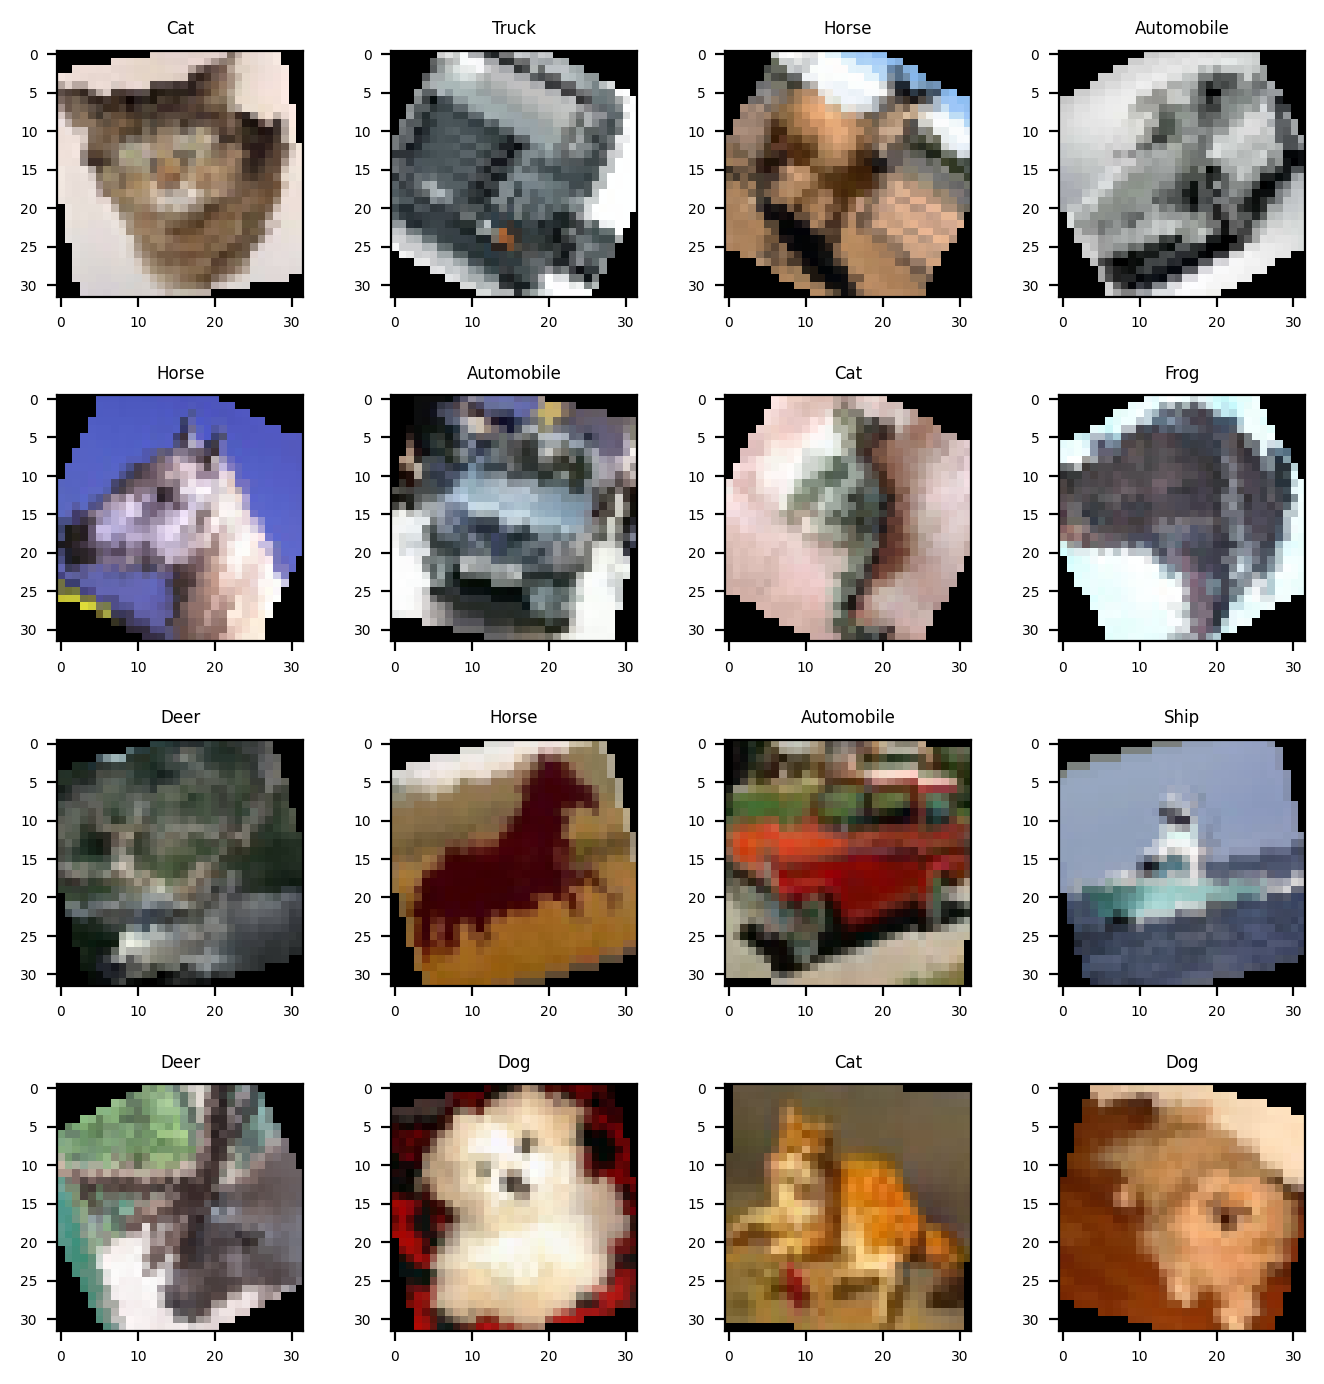

In [13]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 5})

CIFAR10_labels = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
}

images, labels = next(iter(train_loader))

# Define plot size and DPI
fig = plt.figure(figsize=(8, 8), dpi=200)

# Adjust space between subplots
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.4)

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    ax.set_title(CIFAR10_labels.get(int(labels[i])))
    img = images[i].numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1.)
    plt.imshow(img)

plt.show()

Using torch's `nn` module, we can create a logisitic regression model comprised of the following layers:
1. A `ReLU` layer that serves as the activation for `ResNet18`'s last linear layer.
2. A `Linear` layer whose output corresponds to the 10 categories in the [CIFAR 10 Dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html).

We can additionally specify the loss `criterion` and `optimizer` algorithm for our training loop.
- `CrossEntropyLoss()` loss function was selected to train classification with _C_ classes.
- `Adam` optmizer was selected due to it's performant qualities while training.

In [32]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
from torchsummary import summary

# create transfer learning model
resnet18_based = resnet18(weights=ResNet18_Weights.DEFAULT)

for param in resnet18_based.parameters():
    param.requires_grad = False

num_ftrs = resnet18_based.fc.in_features
resnet18_based.fc = nn.Linear(num_ftrs, 10)

resnet18_based.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(resnet18_based.fc.parameters(), lr=1e-3)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.1)

We can now devise a training loop for our `new_classifier`. Each epoch iteration performs a forward and backward pass per batch in the training data and evaluates on validation data after each epoch. The function returns a dictionary containing the model and relevant training statistics.

In [33]:
from tqdm import tqdm

# Define a function to compute accuracy
def calculate_accuracy(outputs, labels):
    
    softmax = nn.Softmax(dim = 1)
    
    outputs = softmax(outputs)
    
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

def train_model(model, criterion, optimizer, train_loader: DataLoader, val_loader: DataLoader = None, scheduler = None, num_epochs=25):

    # model training history
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        model.train()
        
        train_loss = 0
        total_accuracy = 0
        
        # Iterate over data.
        for data in tqdm(train_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # forward pass and loss calculation
            with torch.set_grad_enabled(True):
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)        

                # backward pass
                # loss.requires_grad = True
                loss.backward()
                optimizer.step()

            # training loss per batch    
            train_loss += loss.item()
            
            # training statistics
            batch_accuracy = calculate_accuracy(outputs, labels)
            total_accuracy += batch_accuracy
            
        # update scheduler
        if scheduler != None:
            scheduler.step()

        # validation on epoch
        if val_loader != None:

            # training statistics
            val_loss = 0
            val_accuracy = 0

            # set model to evaluation
            model.eval()

            for data in tqdm(val_loader):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward pass and loss calc
                with torch.no_grad():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()

                val_batch_accuracy = calculate_accuracy(outputs, labels)
                val_accuracy += val_batch_accuracy

        # Calculate average accuracy for the epoch
        epoch_accuracy = total_accuracy / len(train_loader)
        train_acc_history.append(epoch_accuracy)
        
        epoch_loss = train_loss / len(train_loader)
        train_loss_history.append(epoch_loss)
        
        print('Train Loss: {:.4f}\tTrain Accuracy: {:.4f}'.format(epoch_loss, epoch_accuracy))
        
        if val_loader != None:
            
            epoch_val_accuracy = val_accuracy / len(val_loader)
            val_acc_history.append(epoch_val_accuracy)
            
            epoch_val_loss = val_loss / len(val_loader)
            val_loss_history.append(float(epoch_val_loss))
            
            print('Validation Loss: {:.4f}\tValidation Accuracy: {:.4f}\n'.format(epoch_val_loss, epoch_val_accuracy))

    history = {
        "model": model.to("cpu"),
        "train loss": train_loss_history,
        "validation loss": val_loss_history,
        "train accuracy": train_acc_history,
        "validation accuracy": val_acc_history
    }    

    return history



In [34]:
trained_classifier = train_model(resnet18_based, criterion, optimizer, train_loader, val_loader, num_epochs=20)

Epoch 1/20


100%|██████████| 79/79 [00:01<00:00, 67.21it/s]


Train Loss: 1.8924	Train Accuracy: 0.3242
Validation Loss: 1.8018	Validation Accuracy: 0.3671

Epoch 2/20


100%|██████████| 79/79 [00:01<00:00, 68.74it/s]


Train Loss: 1.7827	Train Accuracy: 0.3689
Validation Loss: 1.7452	Validation Accuracy: 0.3924

Epoch 3/20


100%|██████████| 79/79 [00:01<00:00, 74.66it/s]


Train Loss: 1.7721	Train Accuracy: 0.3725
Validation Loss: 1.7579	Validation Accuracy: 0.3839

Epoch 4/20


100%|██████████| 79/79 [00:01<00:00, 71.55it/s]


Train Loss: 1.7614	Train Accuracy: 0.3762
Validation Loss: 1.7500	Validation Accuracy: 0.3859

Epoch 5/20


100%|██████████| 79/79 [00:01<00:00, 70.53it/s]


Train Loss: 1.7501	Train Accuracy: 0.3805
Validation Loss: 1.7557	Validation Accuracy: 0.3859

Epoch 6/20


100%|██████████| 79/79 [00:01<00:00, 73.65it/s]


Train Loss: 1.7616	Train Accuracy: 0.3781
Validation Loss: 1.7232	Validation Accuracy: 0.3884

Epoch 7/20


100%|██████████| 79/79 [00:01<00:00, 70.77it/s]


Train Loss: 1.7572	Train Accuracy: 0.3778
Validation Loss: 1.7682	Validation Accuracy: 0.3776

Epoch 8/20


100%|██████████| 79/79 [00:01<00:00, 70.23it/s]


Train Loss: 1.7510	Train Accuracy: 0.3781
Validation Loss: 1.7812	Validation Accuracy: 0.3841

Epoch 9/20


100%|██████████| 79/79 [00:01<00:00, 71.92it/s]


Train Loss: 1.7616	Train Accuracy: 0.3747
Validation Loss: 1.7370	Validation Accuracy: 0.3970

Epoch 10/20


100%|██████████| 79/79 [00:01<00:00, 73.75it/s]


Train Loss: 1.7568	Train Accuracy: 0.3779
Validation Loss: 1.7465	Validation Accuracy: 0.3855

Epoch 11/20


100%|██████████| 79/79 [00:01<00:00, 69.16it/s]


Train Loss: 1.7502	Train Accuracy: 0.3843
Validation Loss: 1.7198	Validation Accuracy: 0.3914

Epoch 12/20


100%|██████████| 79/79 [00:01<00:00, 72.19it/s]


Train Loss: 1.7613	Train Accuracy: 0.3791
Validation Loss: 1.7590	Validation Accuracy: 0.3865

Epoch 13/20


100%|██████████| 79/79 [00:01<00:00, 67.46it/s]


Train Loss: 1.7553	Train Accuracy: 0.3787
Validation Loss: 1.7589	Validation Accuracy: 0.3794

Epoch 14/20


100%|██████████| 79/79 [00:01<00:00, 70.03it/s]


Train Loss: 1.7522	Train Accuracy: 0.3827
Validation Loss: 1.7375	Validation Accuracy: 0.3920

Epoch 15/20


100%|██████████| 79/79 [00:01<00:00, 68.32it/s]


Train Loss: 1.7539	Train Accuracy: 0.3821
Validation Loss: 1.7179	Validation Accuracy: 0.3960

Epoch 16/20


100%|██████████| 79/79 [00:01<00:00, 72.31it/s]


Train Loss: 1.7627	Train Accuracy: 0.3778
Validation Loss: 1.7099	Validation Accuracy: 0.3987

Epoch 17/20


100%|██████████| 79/79 [00:01<00:00, 71.19it/s]


Train Loss: 1.7555	Train Accuracy: 0.3799
Validation Loss: 1.7595	Validation Accuracy: 0.3794

Epoch 18/20


100%|██████████| 79/79 [00:01<00:00, 71.87it/s]


Train Loss: 1.7516	Train Accuracy: 0.3825
Validation Loss: 1.7550	Validation Accuracy: 0.3795

Epoch 19/20


100%|██████████| 79/79 [00:01<00:00, 72.52it/s]


Train Loss: 1.7555	Train Accuracy: 0.3823
Validation Loss: 1.7326	Validation Accuracy: 0.3910

Epoch 20/20


100%|██████████| 79/79 [00:01<00:00, 72.69it/s]

Train Loss: 1.7489	Train Accuracy: 0.3823
Validation Loss: 1.7613	Validation Accuracy: 0.3883



The `trained_classifier` dictionary can now be passed to the `model_history()` function to plot accuracy and loss history.

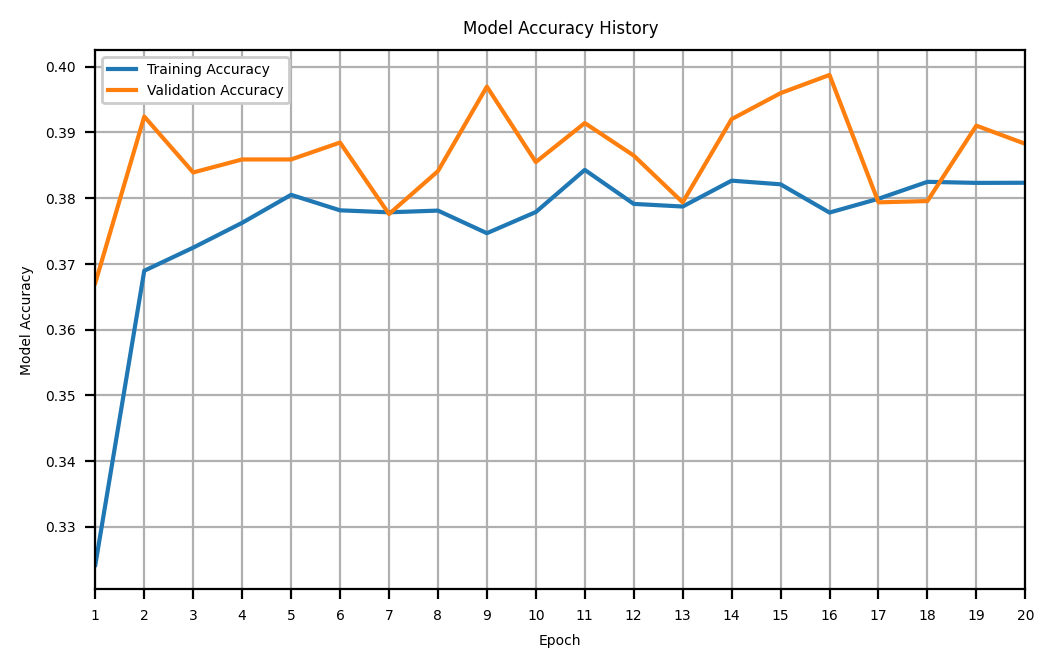

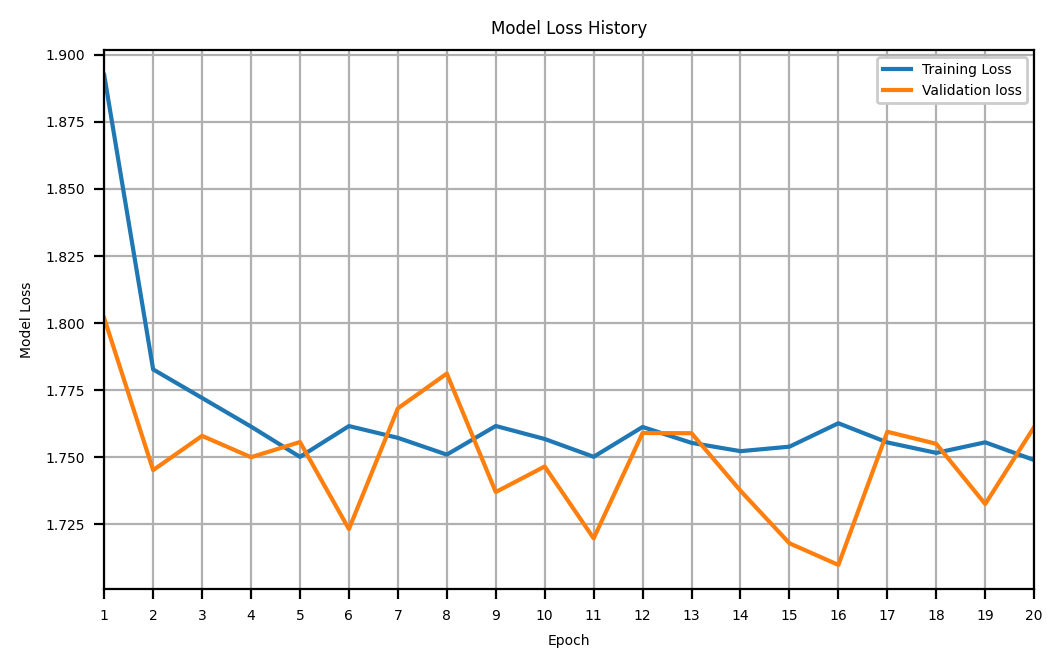

In [35]:
# create function to show model training accuracy and loss history
def model_history(history):
        # plot training history
        fig, ax = plt.subplots(figsize=(6,3.5), dpi=200)

        ax.plot(range(1,len(history['train accuracy'])+1),
                history['train accuracy'],
                label = r'Training Accuracy',
                #marker = 'o',
                markersize = 4)

        ax.plot(range(1, len(history["validation accuracy"])+1),
                history['validation accuracy'],
                label = r'Validation Accuracy',
                #marker = 'o',
                markersize = 4)

        ax.set_title("Model Accuracy History")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Model Accuracy')
        ax.set_xlim(1, len(history["train accuracy"]))
        ax.set_xticks(list(range(1,len(history["train accuracy"])+1)))
        ax.legend()
        ax.legend().get_frame().set_alpha(1.0)

        ax.grid(True)

        # plot loss history
        fig, ax = plt.subplots(figsize=(6,3.5), dpi=200)

        ax.plot(range(1,len(history['train loss'])+1),
                history['train loss'],
                label = r'Training Loss',
                #marker = 'o',
                markersize = 4)

        ax.plot(range(1, len(history["validation loss"])+1),
                history['validation loss'],
                label = r'Validation loss',
                #marker = 'o',
                markersize = 4)

        ax.set_title("Model Loss History")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Model Loss')
        ax.set_xlim(1, len(history["train loss"]))
        ax.set_xticks(list(range(1,len(history["train loss"])+1)))
        ax.legend()
        ax.legend().get_frame().set_alpha(1.0)

        ax.grid(True)

# plot training history using the function
model_history(trained_classifier)

We next define the `evaluation` function to evaluate the trained model on the `extracted_test_loader` dataset. Similar to our training loop, this function returns a dictionary of relevant items for analysis and further visual inspection. Namely:
1. Test set accuracy
2. Test set loss
3. Label predictions
4. True labels
5. Softmax probabilities

In [24]:
from sklearn.metrics import accuracy_score

def evaluate(model, test_loader):

    model.to(device)
    model.eval()
    softmax = nn.Softmax(dim=1).to(device)
    
    probs_list = []
    y_true = []
    
    test_loss = 0
    
    for data in tqdm(test_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_true.append(labels)

        with torch.no_grad():
            
            # forward pass and loss on model
            linear_outputs = model(inputs)
            loss = criterion(linear_outputs, labels)

        # apply softmax layer
        outputs = softmax(linear_outputs)
        
        # add loss to total
        test_loss += loss.item()
        
        # append softmax probabilities to probs_list
        for prob, label in zip(outputs, labels):
            probs_list.append(prob.cpu().tolist())
            
    
    y_true = torch.cat(y_true, dim=0).cpu()
    
    # compute total loss on test set
    test_loss /= len(test_loader)
    
    # get predicitons
    y_pred = list(np.argmax(np.asarray(probs_list), axis = 1))
    
    # report accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    print("Test Accuracy:", accuracy)
    print("Test Loss: {:.4f}".format(test_loss))
    
    # return dictionary
    evaluation = {
        "accuracy": accuracy,
        "loss": test_loss,
        "y_pred": list(y_pred),
        "y_true": list(y_true),
        "probs": list(probs_list)
    }
    
    return evaluation
        
test_results = evaluate(trained_classifier["model"], test_loader)

100%|██████████| 79/79 [00:01<00:00, 39.89it/s]


Test Accuracy: 0.831
Test Loss: 0.4933


In [25]:
import pandas as pd

def prediction_results(test_results: dict = test_results, test_set = test_set):
    
    # create dataframe from test results for data manipulation
    df = pd.DataFrame(test_results, columns = test_results.keys()).drop(["accuracy", "loss"], axis=1).reset_index()

    # add predicted and true labels to the dataframe
    df["pred_class"] = df["y_pred"].apply(
        lambda x: CIFAR10_labels[int(x)]
    )

    df["true_class"] = df["y_true"].apply(
        lambda x: CIFAR10_labels[int(x)]
    )

    # obtain predicted class probability
    df["pred_prob"] = df["probs"].apply(
        lambda x: np.max(x)
    )
    
    # create list of dataframes of top best and worst predictions
    best_predictions = []
    worst_predictions = []
    
    for label in list(CIFAR10_labels.keys()):
        
        # create dataframes of top 5 best and worst predictions
        best_prediction = df.query(str(label)+" == y_true == y_pred").sort_values(by="pred_prob", ascending=False).head(5)
        worst_prediction = df.query(str(label)+" == y_pred != y_true").sort_values(by="pred_prob", ascending=False).head(5)
        
        # append to list of predictions
        best_predictions.append(best_prediction)
        worst_predictions.append(worst_prediction)
    
    # define functino for plotting
    def plotter(df):
        fig = plt.figure(figsize=(10,2), dpi = 200)

        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=0.4)

        for i, (idx, row) in enumerate(df.iterrows()):

            ax = fig.add_subplot(1, 5, i+1)
            ax.set_title(
                f"Predicted Class: {row[4]}\n"+
                f"True Class: {row[5]}\n"+
                f"Predicted Class Probability: {row[6]: .4f}"
            )
            
            ## print(CIFAR10_labels[test_set[idx][1]])
            
            img = test_set[idx][0].numpy().transpose((1, 2, 0))
            img = std * img + mean
            img = np.clip(img, 0, 1.)
            img = test_set[idx][0].numpy().transpose((1, 2, 0))
            img = std * img + mean
            img = np.clip(img, 0, 1.)
            plt.imshow(img)
            
    for best_pred, worst_pred in zip(best_predictions, worst_predictions):
        plotter(best_pred)
        plotter(worst_pred)


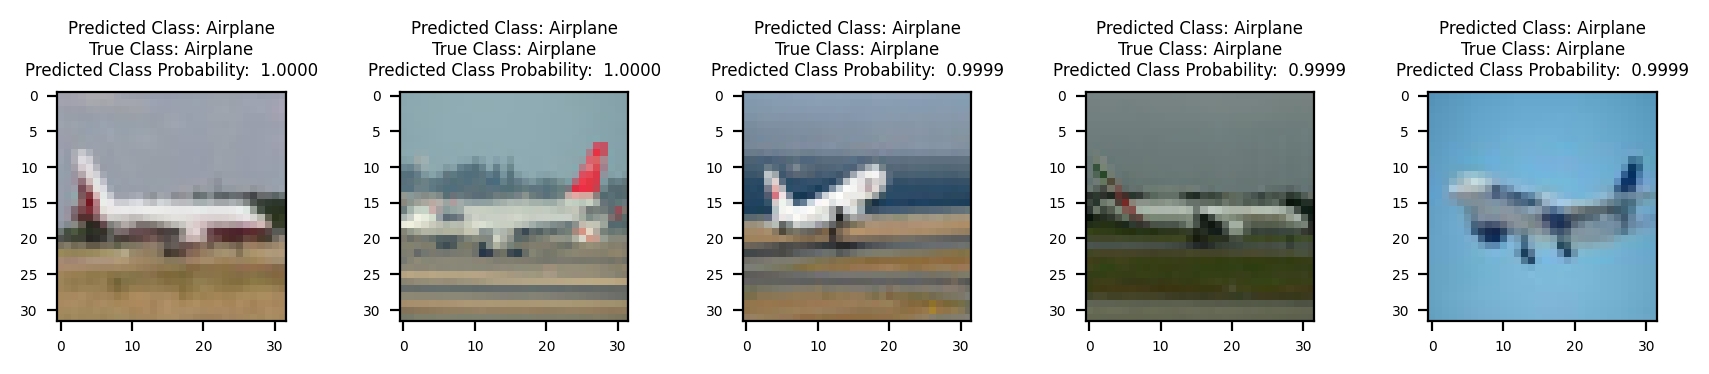

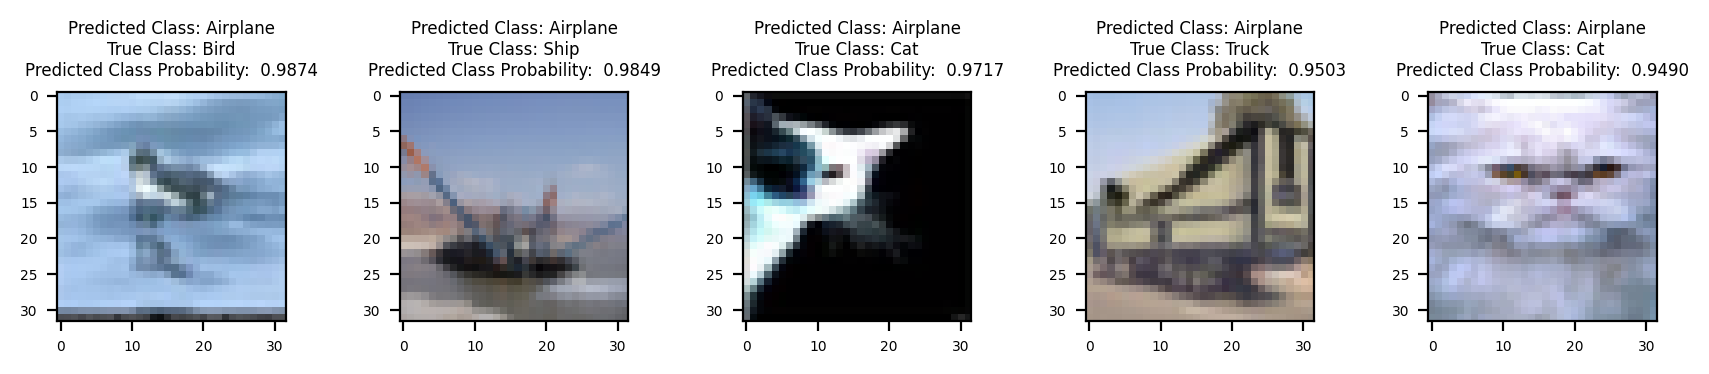

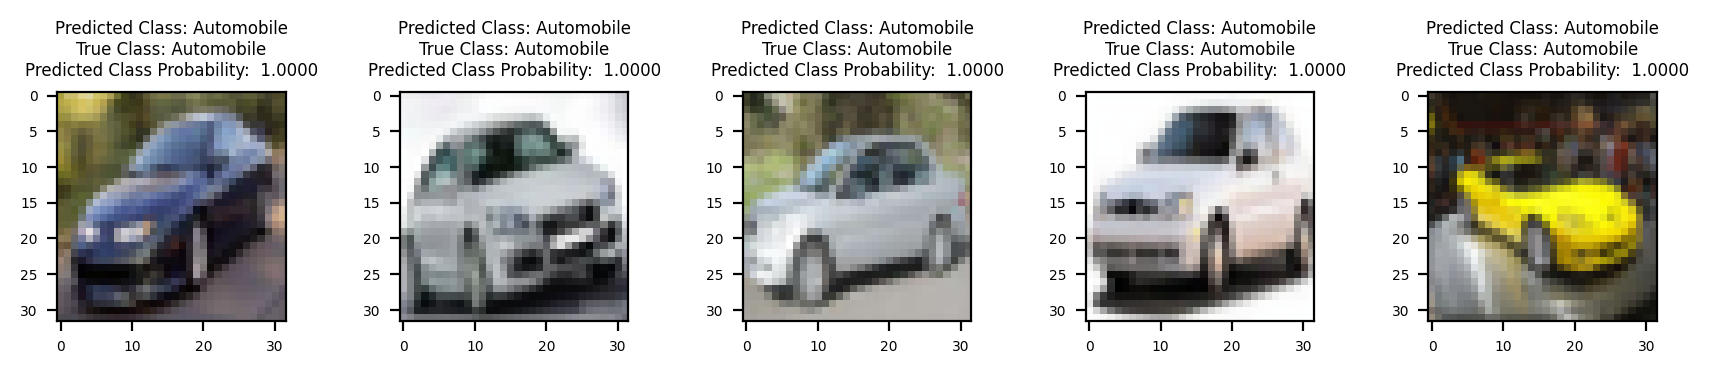

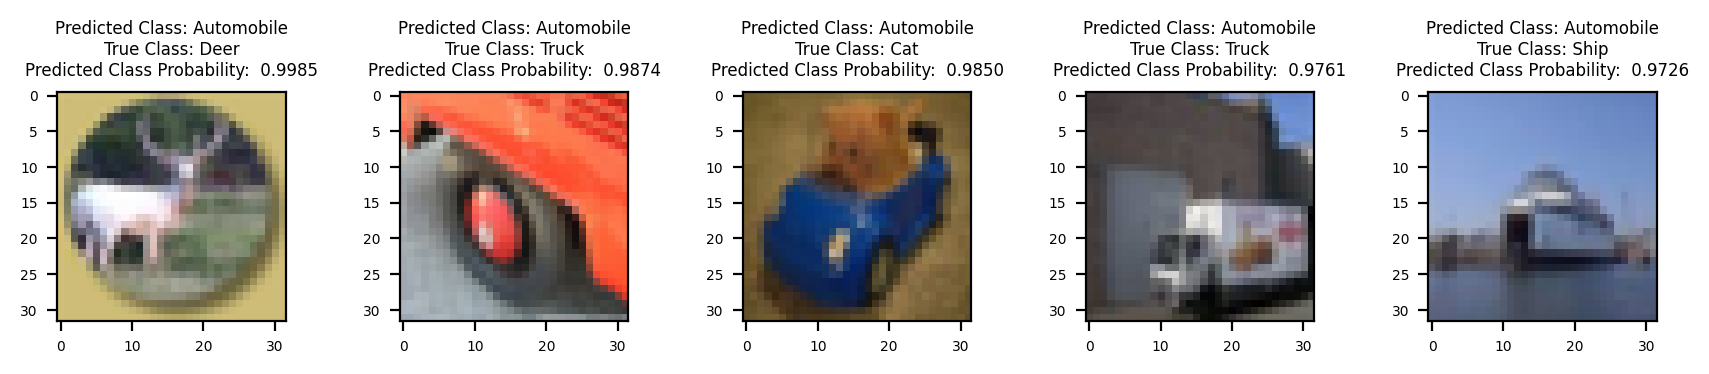

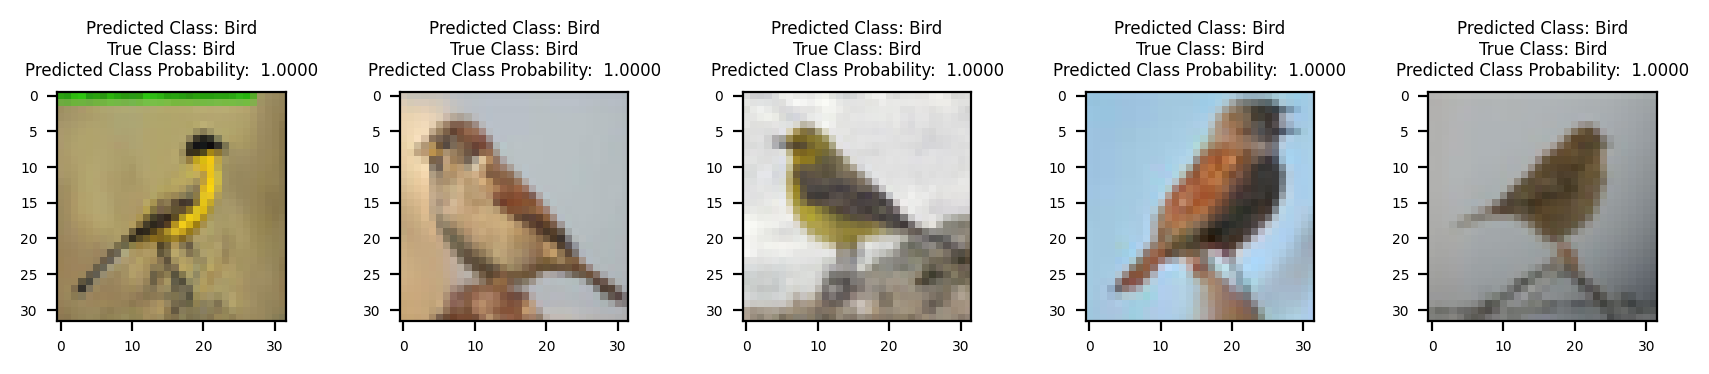

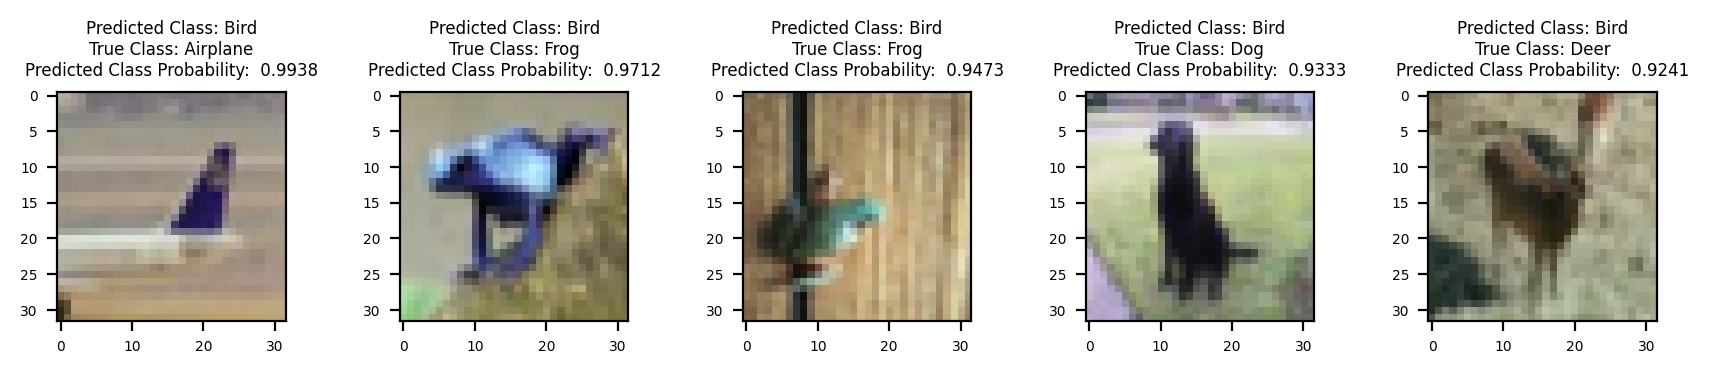

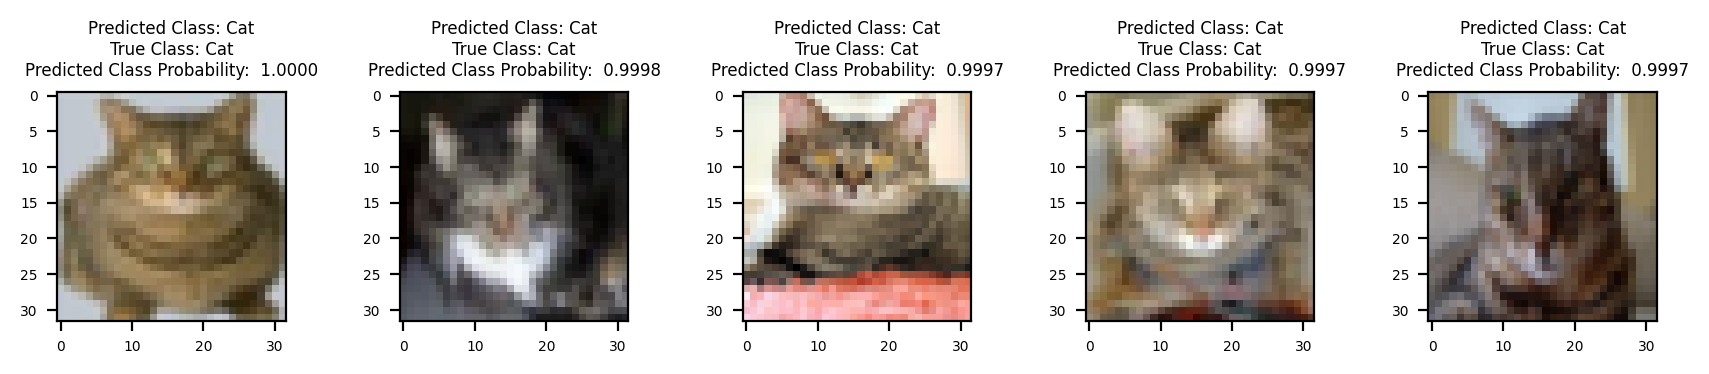

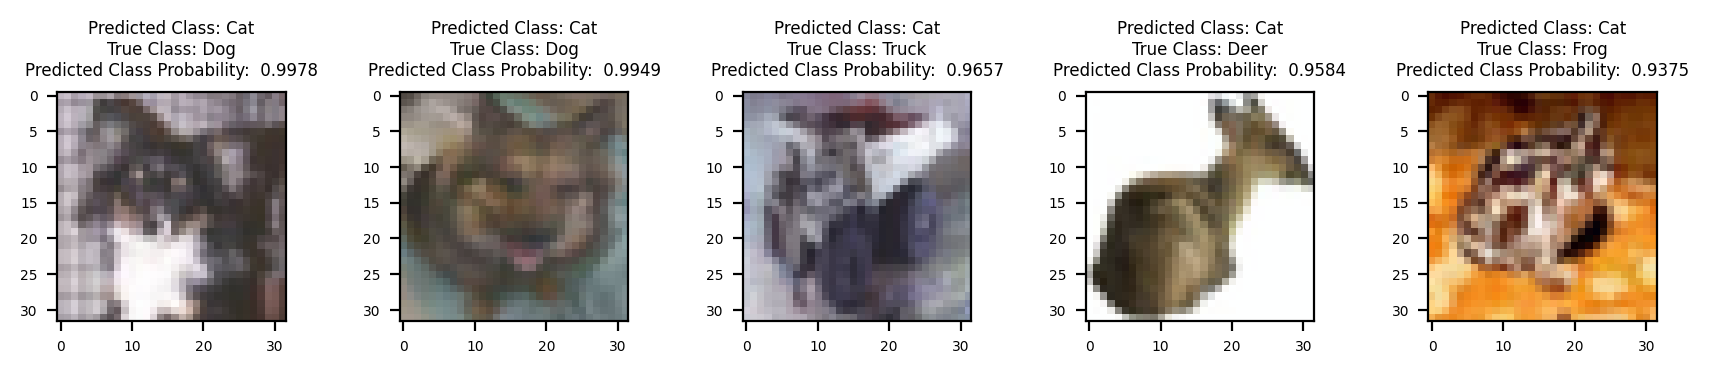

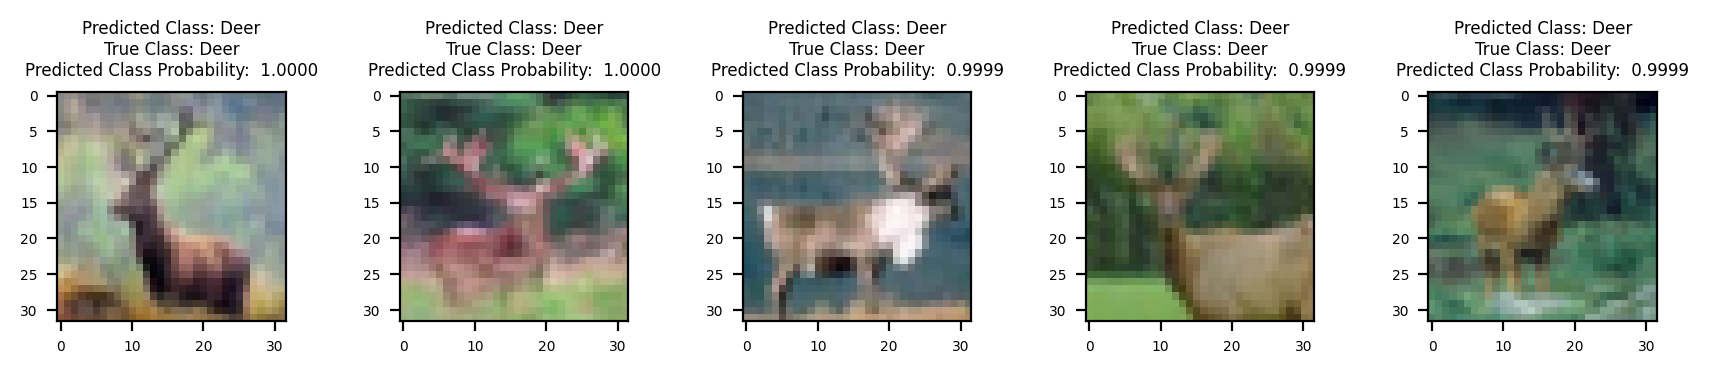

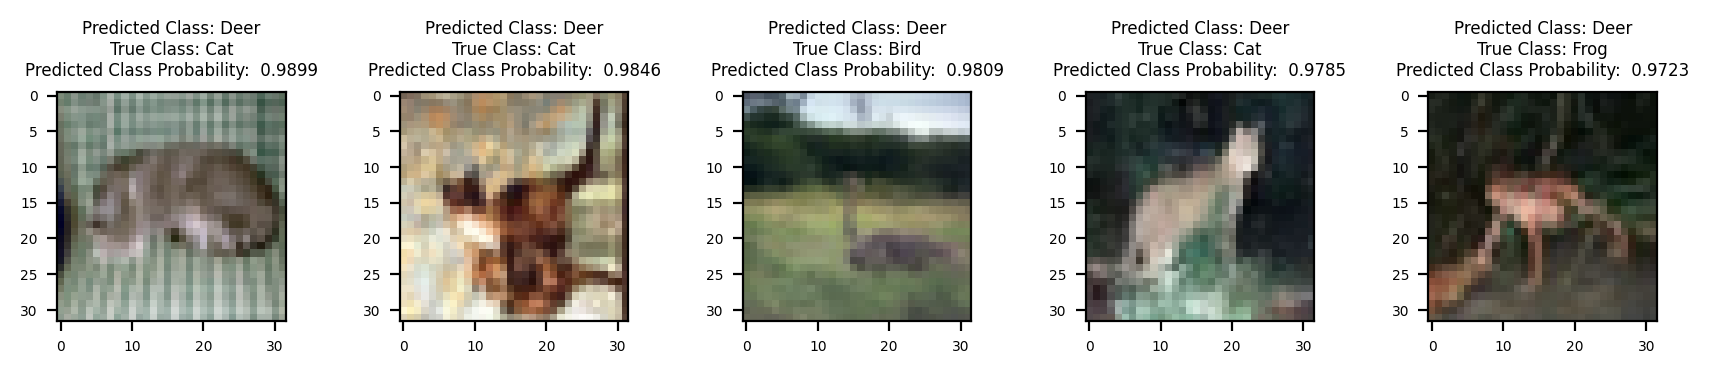

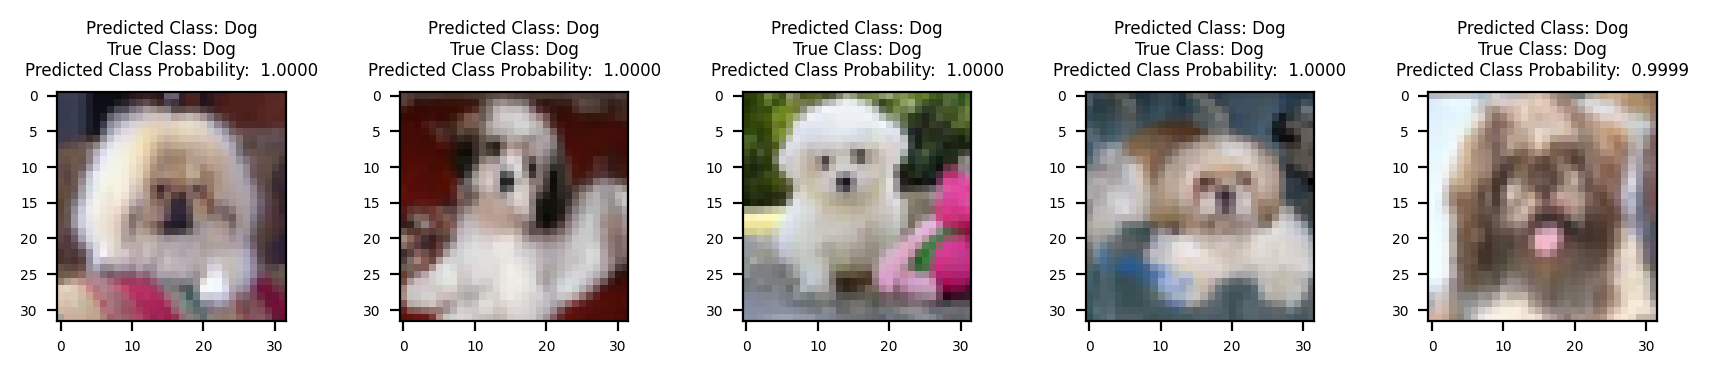

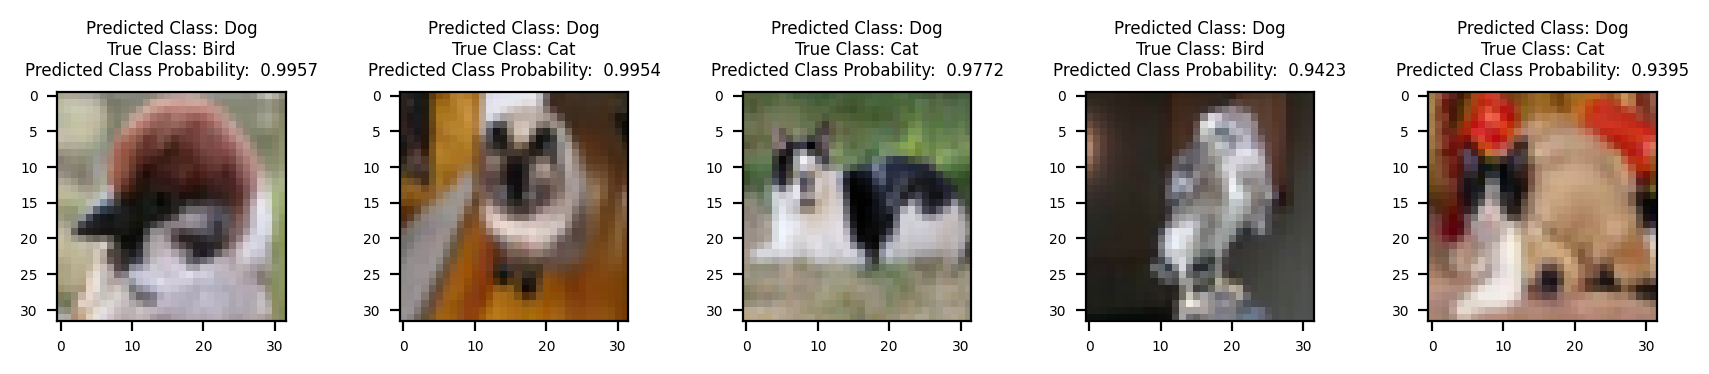

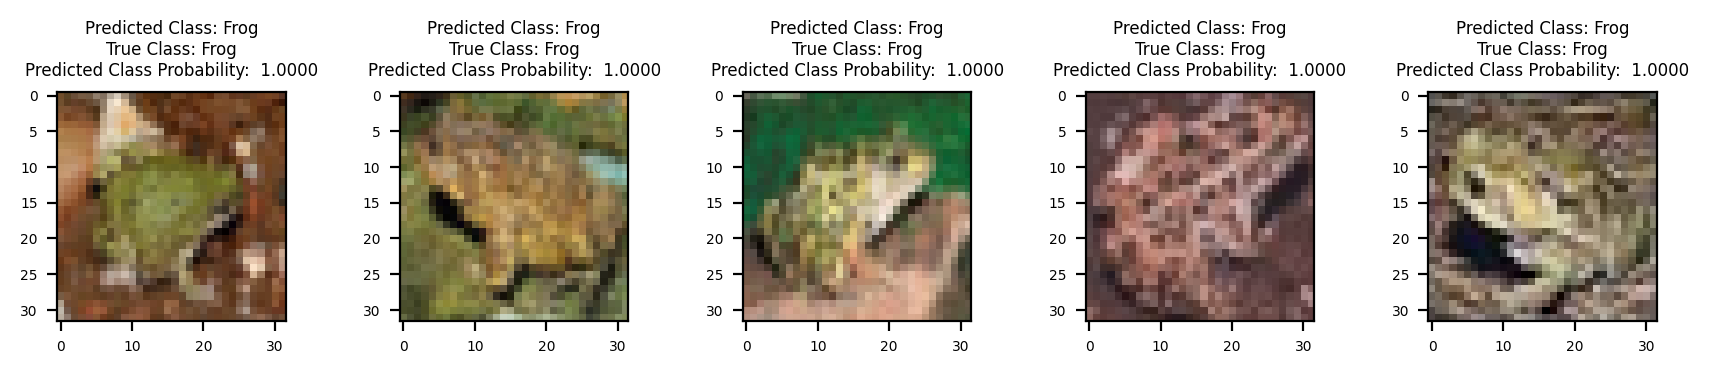

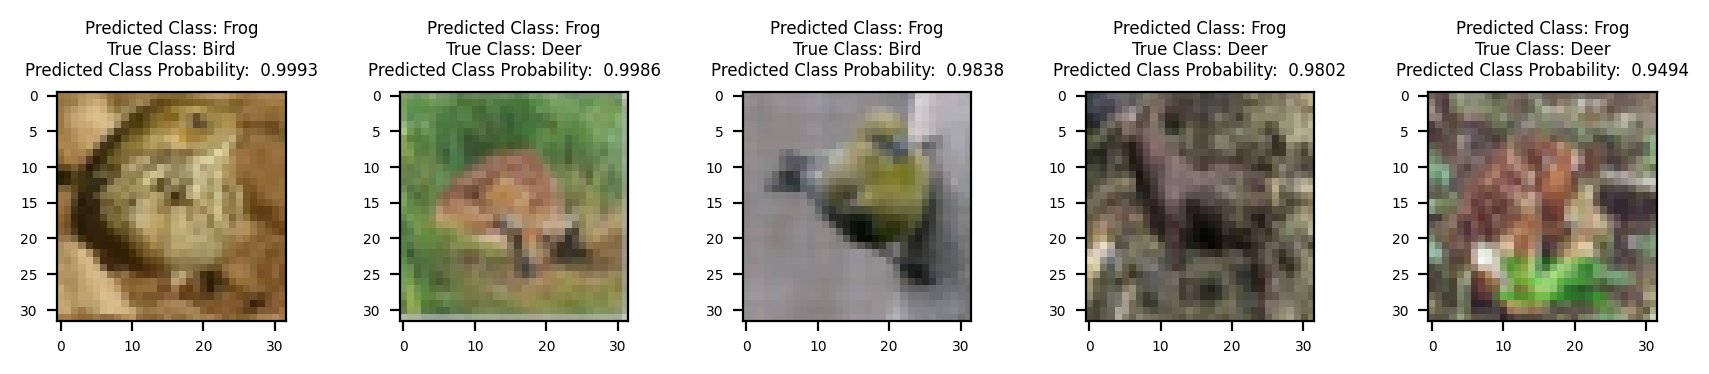

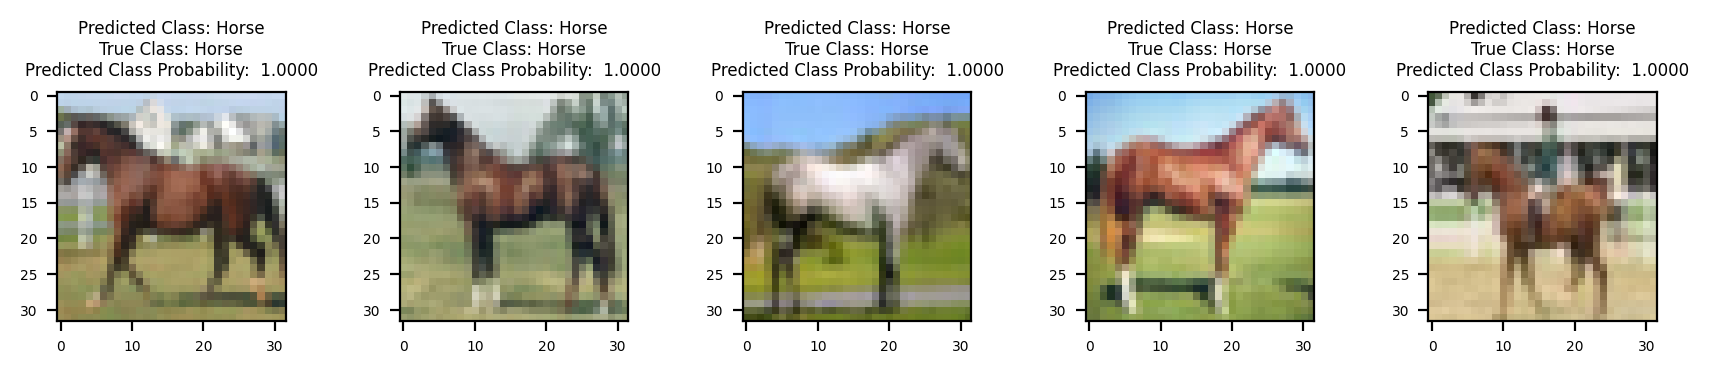

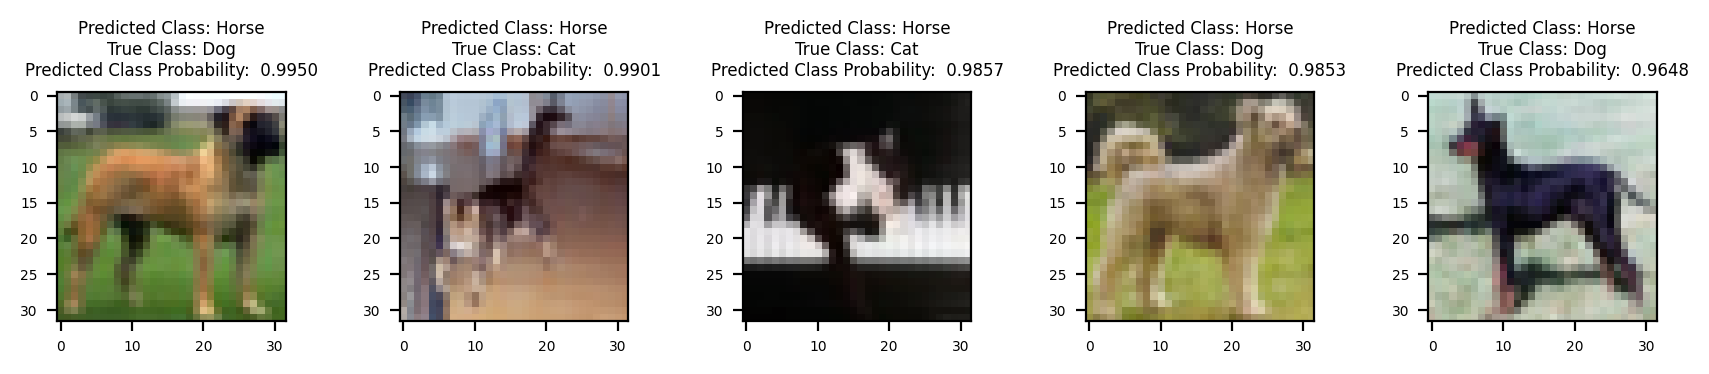

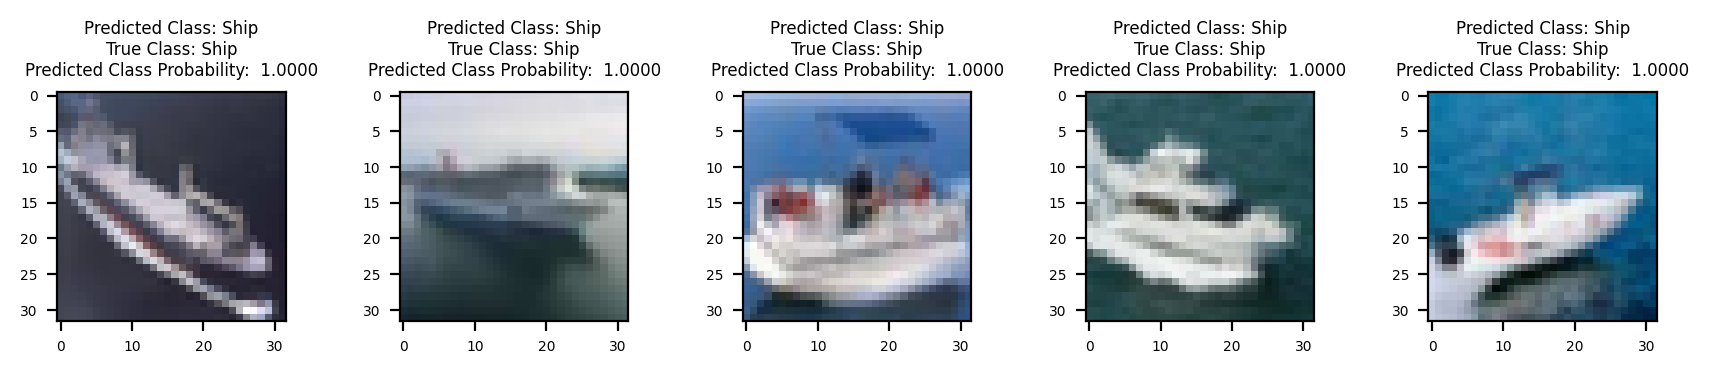

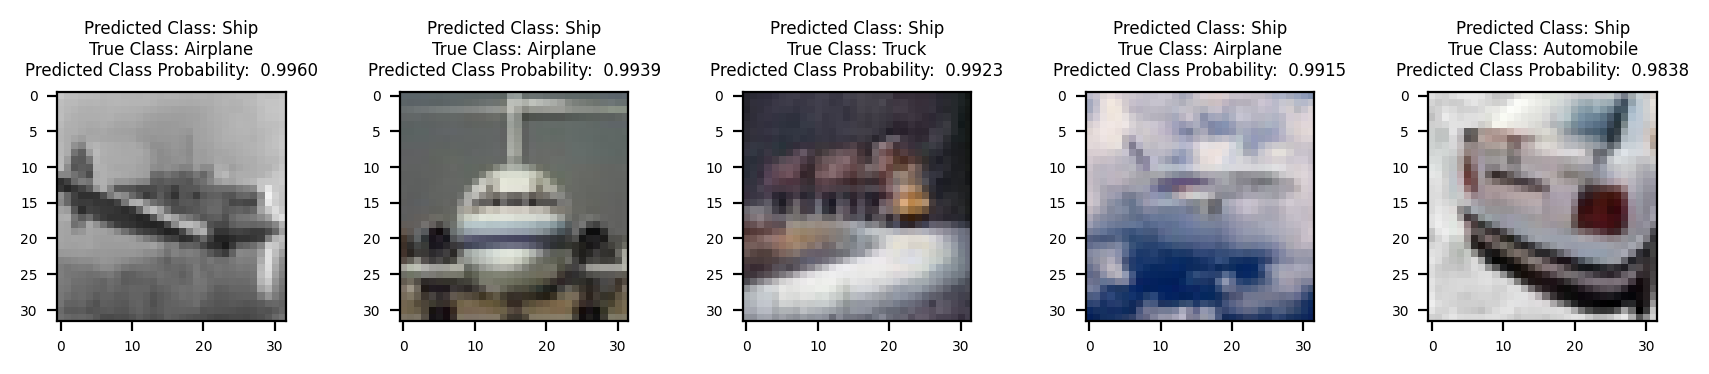

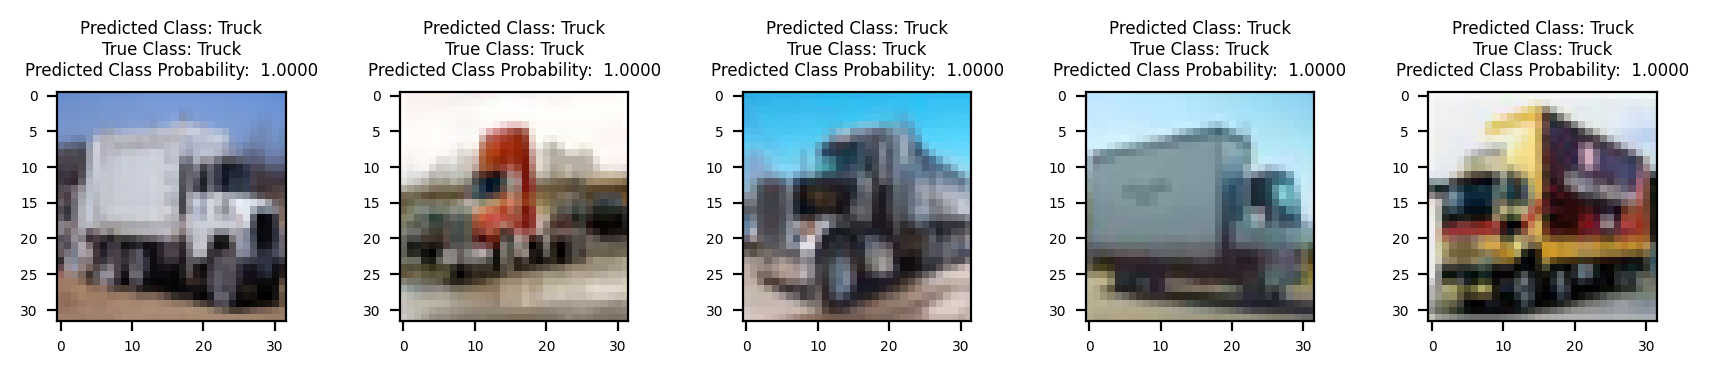

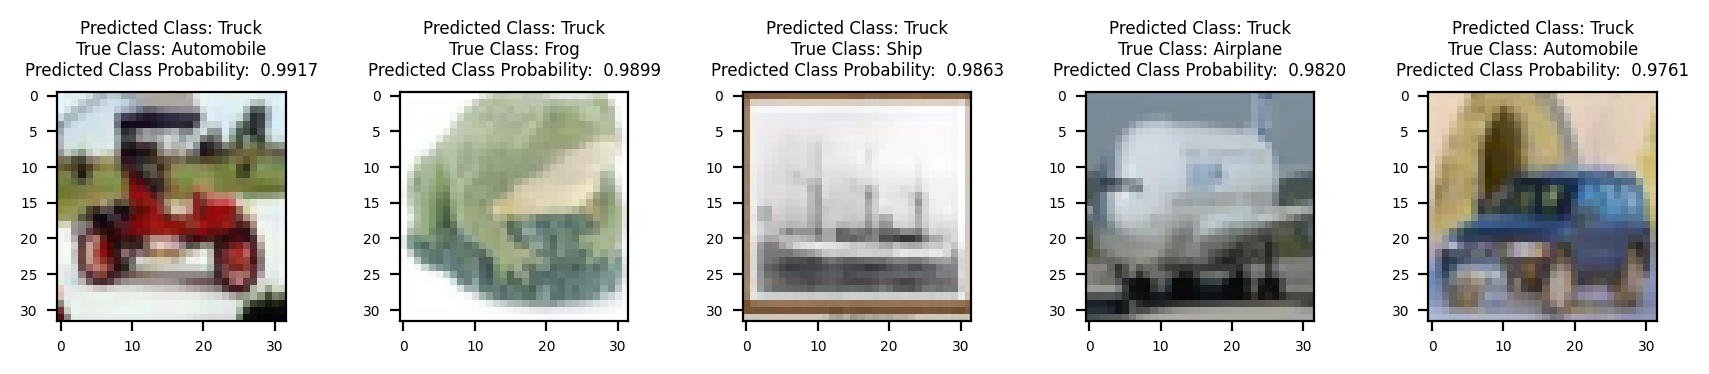

In [26]:
prediction_results(test_results, test_set)